# Анализ воронки продаж


## Описание проекта

Нам предстоит изучить воронку продаж и узнать как пользователи доходят до покупки, а сколько - "застревает" на предыдущих шагах и на каких именно. Далее предстоит исследовать результаты A/A/B-эксперимента, предмет исследования - шрифты во всем приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить какой шрифт лучше.

## Цели и задачи проекта

- Выяснить общее количество пользователей
- Выяснить данные за какой преод представлены в проекте
- Изучение воронки событий
- Где теряется больше всего пользователей
-  Изучение результатов эксперимента
- Выводы

## Описание данных

Каждая запись в логе — это действие пользователя, или событие.

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## План работы

 - Подготовка данных
 - Изучение данных
  - За какой переод данные
  - Количество пользователей
  - Количество событий на пользователя
  - Убрать старые данные
  - Проверка наличия всех групп

- Изучение воронки
  - Конвесрия воронки
  - Шаг, на котором теряется больше всего пользователей
  - Доля пользователей, дошедших до оплаты

- Изучение результатов эксперимента
   - Количество пользователей в группах
   - Самое популярное событие

- Выводы


# Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy import stats as st
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
import datetime as dt
import plotly.express as px

%matplotlib inline

In [ ]:
logs = pd.read_csv('logs_exp', sep='\t')

In [ ]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## 1. Подготовка данных

### 1.1 Для начала переименуем столбцы для удобства в работе

In [ ]:
logs.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

### 1.2 Проверка пропусков

In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Проверим данные на пропуски

In [ ]:
logs.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

### 1.3 Добавление столбцов даты и времени, а также отдельного столбца дат

Пропусков нет. event_timestamp имеет тип int, для восприятия не очень удобно.Создадим новые столбцы для даты и времени в привычном виде, и отдельно даты. Прибавим 3 часа для того, чтобы время было по мск. (В документации этого параметра нет по умолчанию, пришлось делать так, сначала переводим unix в timestamp, потом извлекаем дату, получается object, потом object переводим обратно в timestamp (Если есть менее ресурснозатратный способ с радостью узнаю о нем, я не нашла как быстро и легко оставить только дату))

In [ ]:
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'] + 3*60*60, unit='s')
logs['event_date'] = logs['event_datetime'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
logs['event_date'] = logs['event_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [ ]:
logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 07:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 14:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 14:48:42,2019-07-25


In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   event_datetime   244126 non-null  datetime64[ns]
 5   event_date       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


## 2. Изучение данных

### 2.1 Количество событий в логе

In [ ]:
print(f'Количество уникальных событий: {logs.event_name.nunique()}\nНазвание событий: {logs.event_name.unique()}')
print(f'\nОбщее количество событий: {logs.event_name.count()}')

Количество уникальных событий: 5
Название событий: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']

Общее количество событий: 244126


### 2.2 Количество пользователей в логе

In [ ]:
logs['device_id_hash'].nunique()

7551

### 2.3 Среднее количество событий, приходящихся на пользователя

In [ ]:
logs.groupby('device_id_hash', as_index=False).agg({'event_name': 'count'})['event_name'].mean()

32.33028737915508

In [ ]:
logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 07:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 14:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 14:48:42,2019-07-25


In [ ]:
logs_pivot = logs.pivot_table(index='device_id_hash', columns='event_name', values='event_timestamp', aggfunc='count')
logs_pivot.describe()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
count,3749.000000,7439.000000,4613.000000,3547.000000,847.000000
mean,11.397973,16.024331,10.150661,9.673809,1.242031
std,38.021024,16.281251,16.031384,36.840909,1.930649
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,6.000000,3.000000,2.000000,1.000000
50%,5.000000,11.000000,6.000000,4.000000,1.000000
75%,11.000000,21.000000,12.000000,8.000000,1.000000
max,1101.000000,206.000000,510.000000,1085.000000,50.000000


Выбросы есть во всех показателях, кроме последнего.

### 2.4 Определение минимальной и максимальной даты, гистограмма по дате и времени. Удаление старых данных

In [ ]:
logs['event_datetime'].min()

Timestamp('2019-07-25 07:43:36')

In [ ]:
logs['event_datetime'].max()

Timestamp('2019-08-08 00:15:17')

Временной промежуток с 25 июля 2019 года до 8 августа 2019

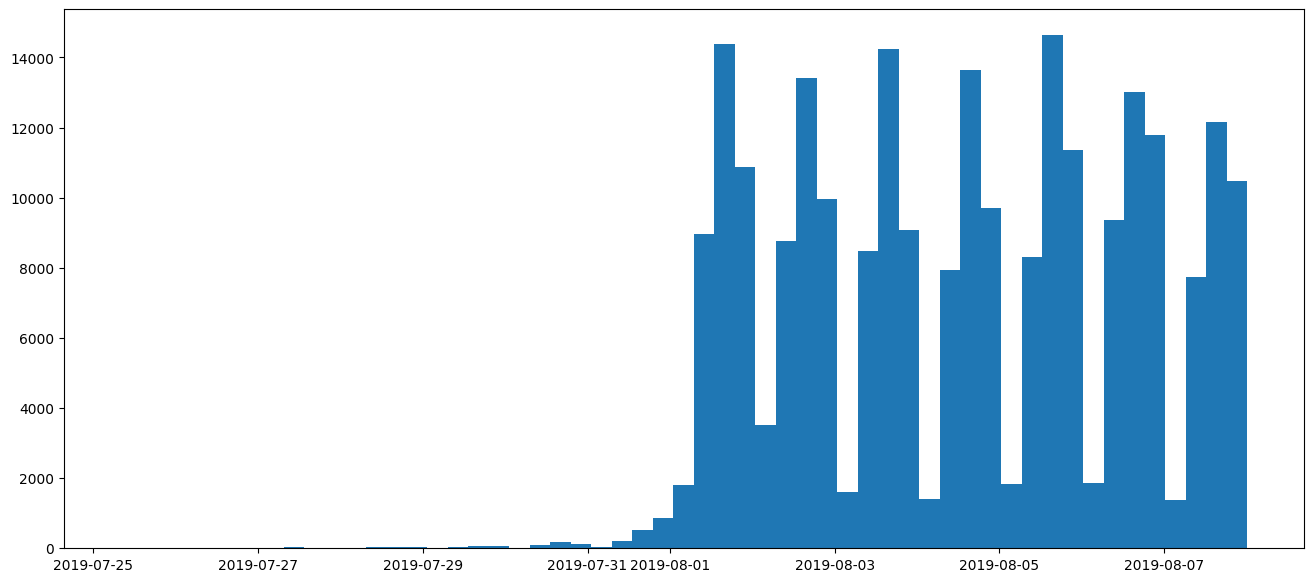

In [ ]:
plt.rcParams["figure.figsize"] = (16,7)
plt.hist(logs['event_datetime'], bins=55);

Из гистограммы видна периодичность данных. Также видно, что рассматривать данные до 2019-08-01 не имеет смысла, их очень мало. На самом деле мы располагаем данными за 7 дней с 2019-08-01 до 2019-08-07, за последний день собрали анализа (2019-08-08) очень маленькое количество данных и его тоже учитывать не будем.



### 2.5 Как много событий и пользователей было потеряно при умньшении времени анализа

In [ ]:
logs_filtered = logs.query('event_date >= "2019-08-01" and event_date <= "2019-08-07"')
print(f'Пользователей потеряно: {logs.device_id_hash.nunique() - logs_filtered.device_id_hash.nunique()}')
print(f'Процент потеряных пользователей: {round((1 - logs_filtered.device_id_hash.nunique() / logs.device_id_hash.nunique()) * 100, 2)} %')
print(f'Событий потеряно: {logs.event_name.count() - logs_filtered.event_name.count()}')
print(f'Процент потеряных событий: {round((1 - logs_filtered.event_name.count() / logs.event_name.count()) * 100, 2)} %')
# print(f'Записей потеряно: {logs.shape[0] - logs_filtered.shape[0]}')
# print(f'Процент потеряных записей: {round((1 - logs_filtered.shape[0] / logs.shape[0]) * 100, 2)} %')

Пользователей потеряно: 13
Процент потеряных пользователей: 0.17 %
Событий потеряно: 2058
Процент потеряных событий: 0.84 %


После выявления акуального периода было потеряно ~0.17% пользователей, а потеря данных (событий) составила 0.84%.

### 2.6 Проверим, что присутствуют пользователи всех 3 групп

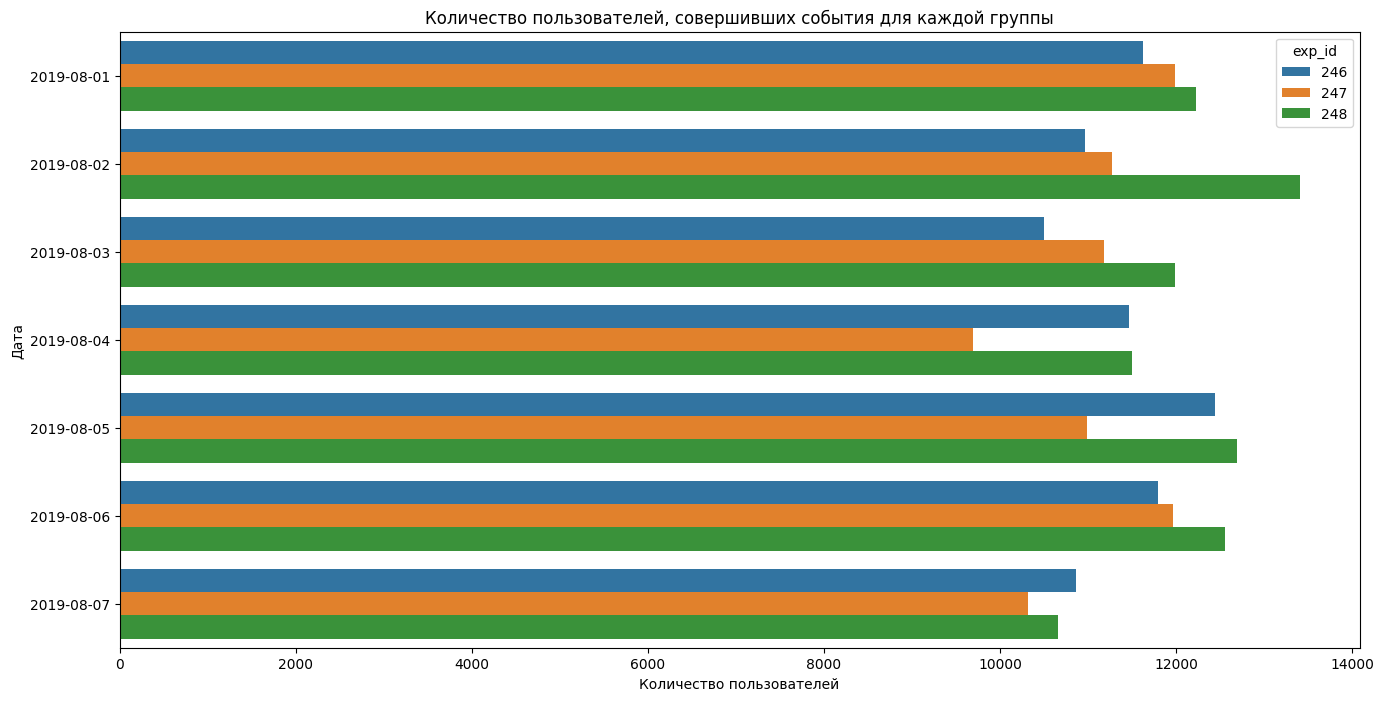

In [ ]:
plt.figure(figsize=(16,8))
sns.countplot(data=logs_filtered, y=logs_filtered['event_date'].dt.strftime('%Y-%m-%d'), hue='exp_id').set_title('Количество пользователей, совершивших события для каждой группы')
plt.xlabel('Количество пользователей')
plt.ylabel('Дата')
plt.show()

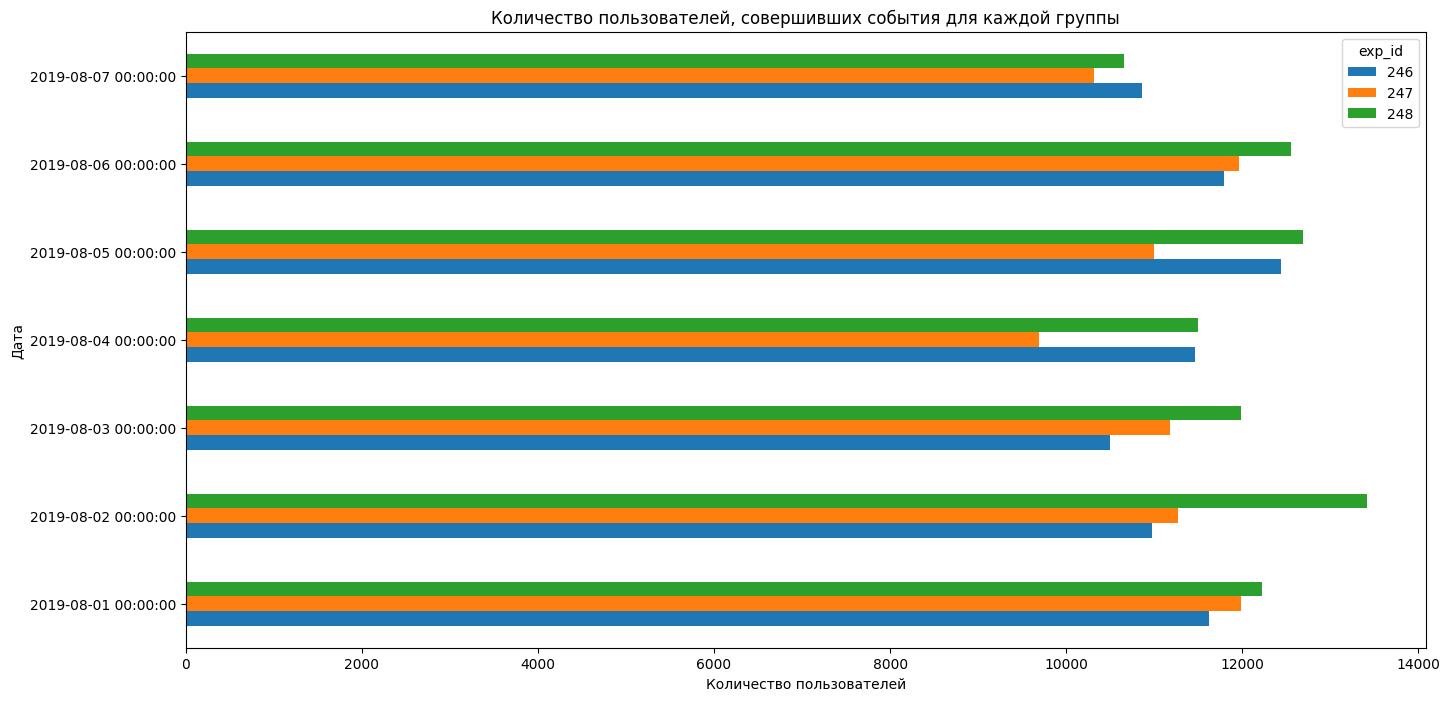

In [ ]:
lf_pivot = logs_filtered.pivot_table(index='event_date', columns='exp_id', values='device_id_hash', aggfunc='count').plot(kind='barh', figsize=(16, 8))
plt.xlabel('Количество пользователей')
plt.ylabel('Дата')
plt.title('Количество пользователей, совершивших события для каждой группы');

Посчитала количество пользователей через сводную таблицу, свопало с первым графиком, я неправильно подписала и это могла ввести в заблуждение.

Как видно из графика присутствуют все группы, среднее количество событий для группы ~11500.

## 3. Изучение воронки событий

### 3.1 Сортировка событий по частоте

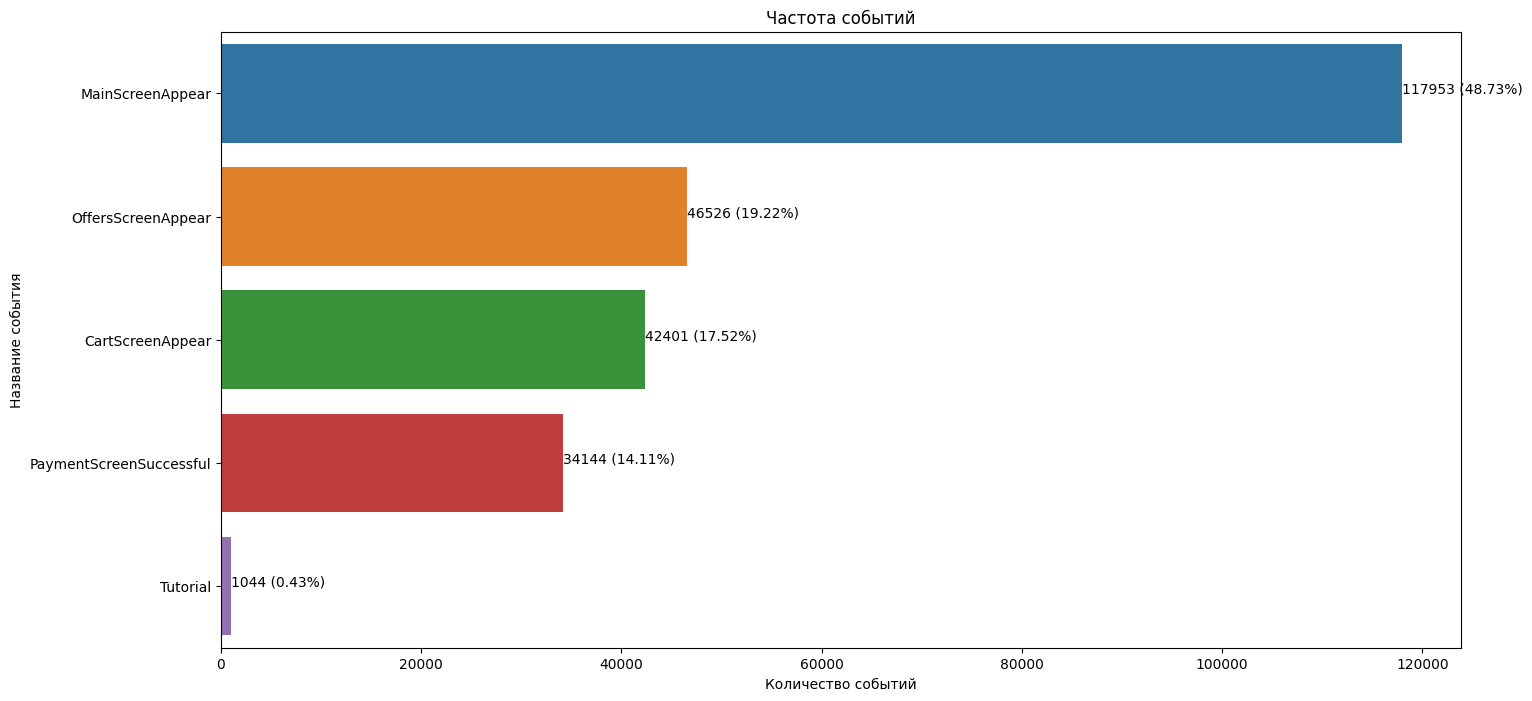

In [ ]:
plt.figure(figsize=(16,8))
ax = sns.countplot(data=logs_filtered, y='event_name', order = logs_filtered['event_name'].value_counts().index)
ax.set_title('Частота событий')
total = len(logs_filtered['event_name'])
for p in ax.patches:
  cnt = str(round(p.get_width())) + ' ({:.2f}%)'.format(100*p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(cnt, (x, y))
plt.xlabel('Количество событий')
plt.ylabel('Название события')
plt.show()

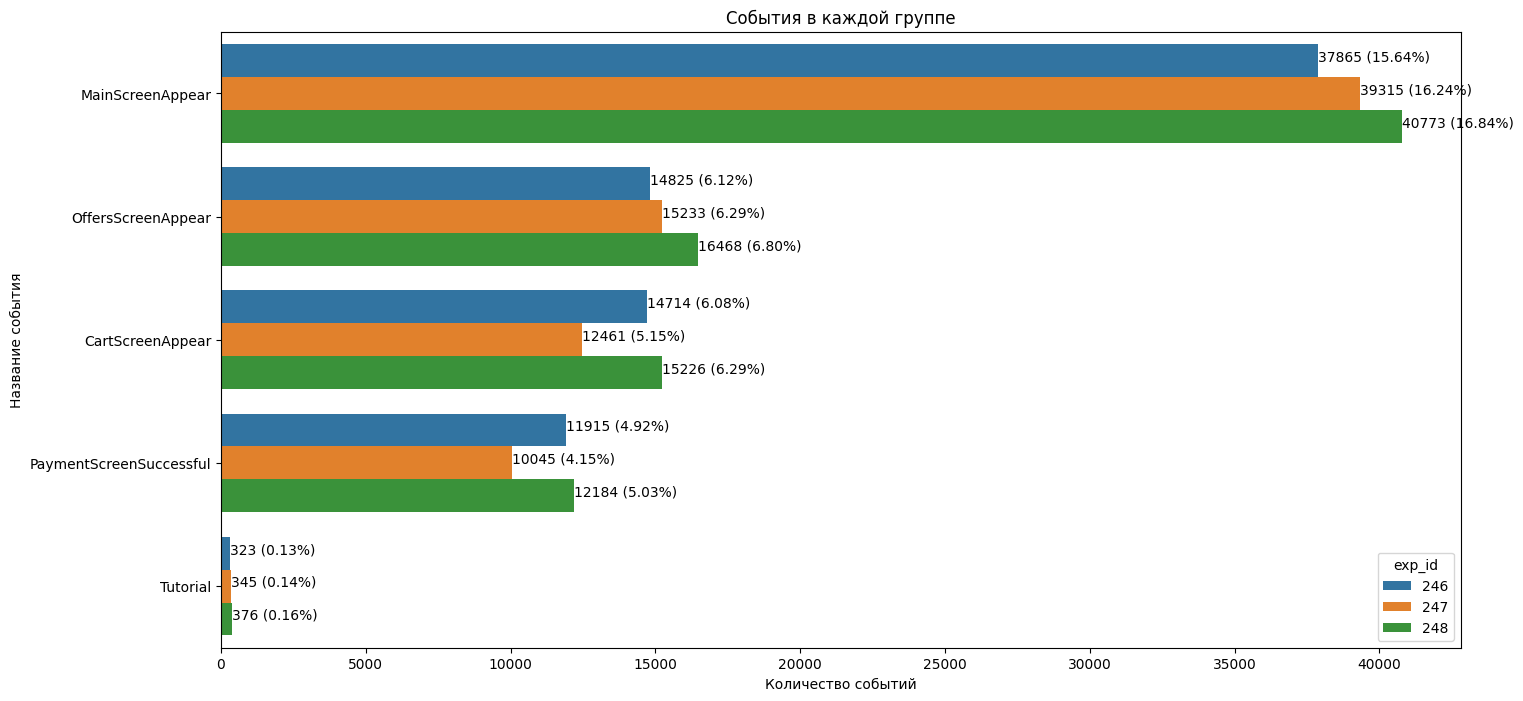

In [ ]:
# Доля пользователей от общего числа
plt.figure(figsize=(16,8))
ax = sns.countplot(data=logs_filtered, y='event_name', order=logs_filtered['event_name'].value_counts().index, hue='exp_id')
ax.set_title('События в каждой группе')
total = len(logs_filtered['event_name'])
for p in ax.patches:
  percentage = str(round(p.get_width())) + ' ({:.2f}%)'.format(100*p.get_width()/total)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage, (x, y))
plt.xlabel('Количество событий')
plt.ylabel('Название события')
plt.show()

Вот список событий:

MainScreenAppear - Пояывление главного экрана

OffersScreenAppear - Экран предложений

CartScreenAppear - Экран корзины

PaymentScreenSuccessful - Экран успешной оплаты

Tutorial - Обучение


### 3.2 Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие

In [ ]:
# Количество пользователей, совершавших каждое событие, отсортированные по числу пользователей
unique_users = logs_filtered.groupby('event_name', as_index=False).agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
unique_users

,event_name,device_id_hash
1,MainScreenAppear,7423
2,OffersScreenAppear,4596
0,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


In [ ]:
logs_filtered['device_id_hash'].nunique()

7538

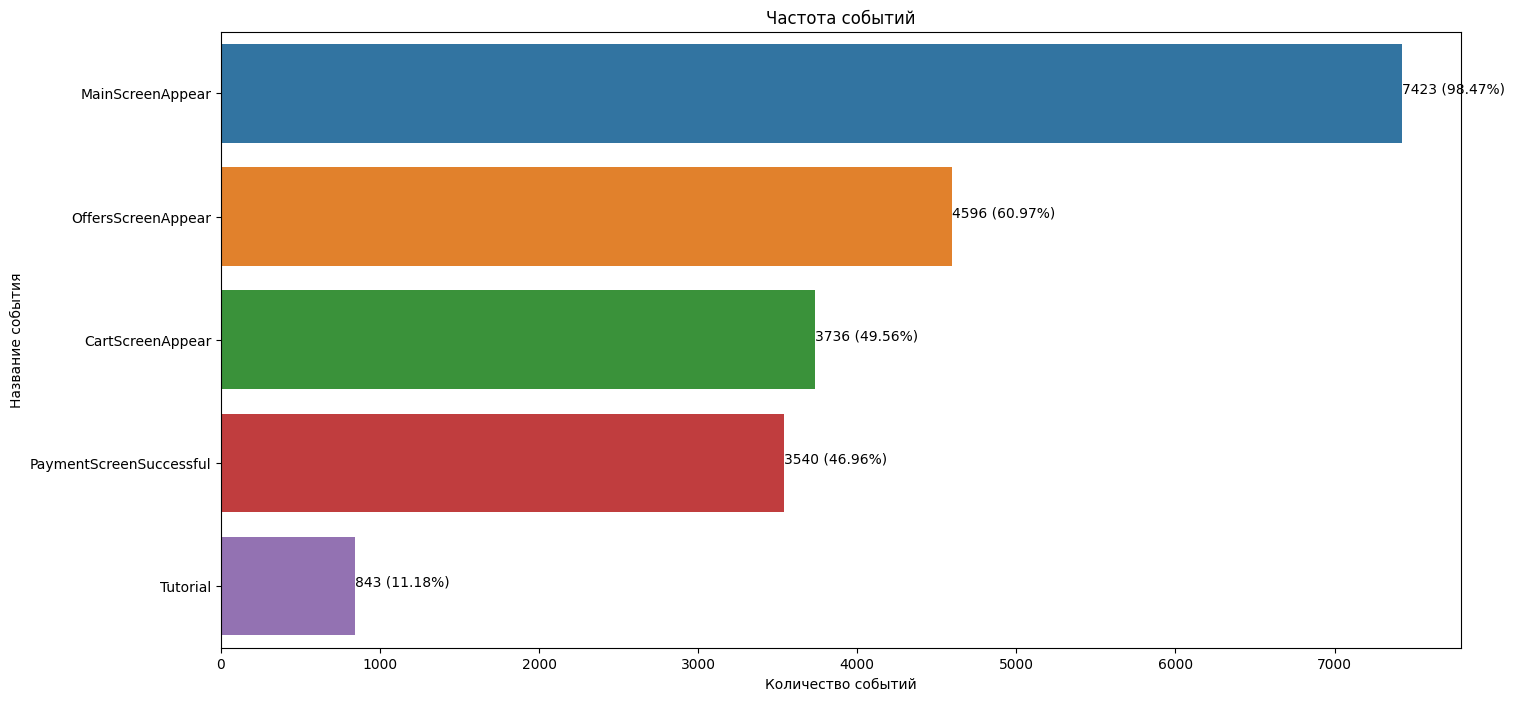

In [ ]:
# Посчитаем долю пользователей, которые хоть раз совершали событие
plt.figure(figsize=(16,8))
ax = sns.barplot(data=unique_users, y='event_name', x='device_id_hash')
ax.set_title('Частота событий')
total_unique = logs_filtered['device_id_hash'].nunique()
# ttl = unique_users['device_id_hash'].sum()
for p in ax.patches:
  perc = str(round(p.get_width())) + ' ({:.2f}%)'.format(100*p.get_width()/total_unique)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(perc, (x, y))
plt.xlabel('Количество событий')
plt.ylabel('Название события')
plt.show()

In [ ]:
unique_users_group = logs_filtered.groupby(['event_name', 'exp_id'], as_index=False).agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)

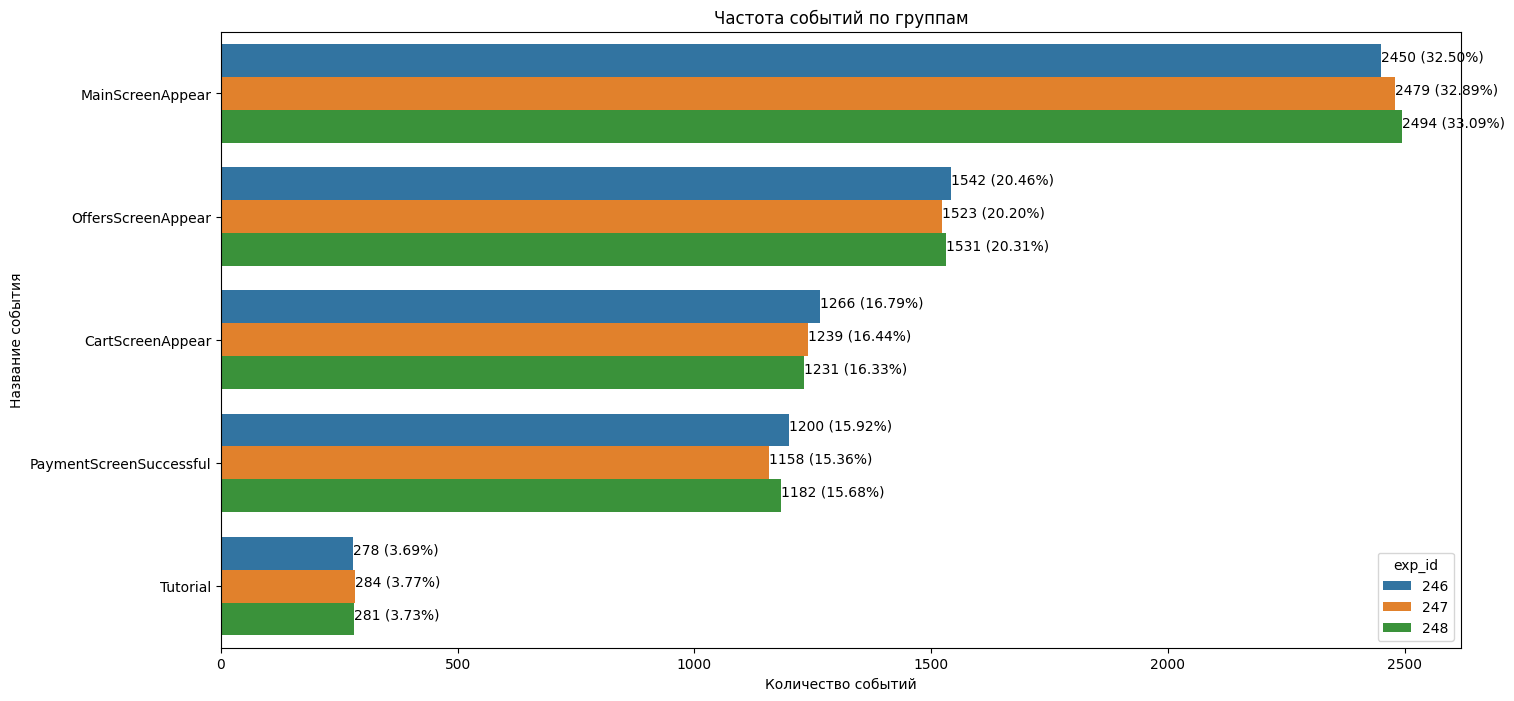

In [ ]:
# Посчитаем долю пользователей от общего числа, которые совершали хотя бы одно событие
plt.figure(figsize=(16,8))
ax = sns.barplot(data=unique_users_group, y='event_name', x='device_id_hash', hue='exp_id')
ax.set_title('Частота событий по группам')
for p in ax.patches:
  perc = str(round(p.get_width())) + ' ({:.2f}%)'.format(100*p.get_width()/total_unique)
  x = p.get_x() + p.get_width() + 0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(perc, (x, y))
plt.xlabel('Количество событий')
plt.ylabel('Название события')
plt.show()

События распределяются в группах достаточно равномерно. Доля пользователей примерно равно между друг другом ~33%. ~98% событий приходится на главный экран.

### 3.3 Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Удалим событие tutorial, оно не является показательным и его прошло меньше 1% от всех пользователей

In [ ]:
logs_filtered = logs_filtered.query('event_name != "Tutorial"')

Предполагаемый порядок событий:
- Главный экран (MainScreenAppear)
- Выбор в корзине предложений (OffersScreenAppear)
- Окно корзины (CartScreenAppear)
- Окно оплаты (PaymentScreenSuccessful)

### 3.4 По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Прохождение обучения занимает очень маленькую долю, поэтому при анализе перехода на следующий шаг учитывать ее не будем.

In [ ]:
def cnt_unique_users(event):
  event_count = logs_filtered[logs_filtered['event_name'] == event]['device_id_hash'].nunique()
  return event_count

In [ ]:
# event = logs_filtered.query('event_name != "Tutorial"').groupby('event_name', as_index=False).agg({'device_id_hash': 'count'}).sort_values(by='device_id_hash', ascending=False).reset_index(drop=True)
event = logs_filtered.groupby('event_name', as_index=False).agg({'device_id_hash': 'count'}).sort_values(by='device_id_hash', ascending=False).reset_index(drop=True)
event.columns = ['event_name', 'cnt_event']
event['unique_users'] = event['event_name'].apply(cnt_unique_users)

In [ ]:
event.unique_users.values

array([7423, 4596, 3736, 3540])

In [ ]:
lst = [event.unique_users[0]]
lst += list(event.unique_users.values)
lst.pop(-1)
lst

[7423, 7423, 4596, 3736]

In [ ]:
event['conversion'] = round(event.unique_users.div(lst) *  100, 2)
event['percentage'] = round(event['unique_users'] / event['unique_users'][0] * 100, 2)
event

,event_name,cnt_event,unique_users,conversion,percentage
0,MainScreenAppear,117953,7423,100.00,100.00
1,OffersScreenAppear,46526,4596,61.92,61.92
2,CartScreenAppear,42401,3736,81.29,50.33
3,PaymentScreenSuccessful,34144,3540,94.75,47.69


Больше всего пользователей теряется на втором шаге (38.08%). До оплаты доходит 47% пользователей.

In [ ]:
data = dict(
    perc=list(event['percentage']),
    event_name=list(event['event_name'])
)
fig = px.funnel(data, x='perc', y='event_name')
fig.show()

## 5. Изучение результатов эксперимента

### 5.1 Количество пользователей в каждой группе

In [ ]:
logs_filtered.groupby('exp_id', as_index=False).agg({'device_id_hash': 'nunique'})

,exp_id,device_id_hash
0,246,2483
1,247,2516
2,248,2535


Кажется, что различие в нескольких десятках людей незначительно и группы равны

In [ ]:
logs_filtered.groupby('device_id_hash', as_index=False)[['exp_id', 'device_id_hash']].agg({'exp_id': 'nunique'}).sort_values(by='exp_id', ascending=False)

,device_id_hash,exp_id
0,6888746892508752,1
5018,6207091767962101846,1
5030,6217295124800833842,1
5029,6216080220799726690,1
5028,6215559225876063378,1
...,...,...
2507,3171891164497446149,1
2506,3171454373076660766,1
2505,3170212200647575044,1
2504,3167974726645136146,1


Никто из пользователей не попадал в несколько групп одновременно

Посмотрим на количество пользователей для каждой гуппы в событиях

In [ ]:
group_table = logs_filtered.pivot_table(index='exp_id',
                                        columns='event_name',
                                        values='device_id_hash',
                                        aggfunc='nunique')
group_table

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
exp_id,,,,
246,1266,2450,1542,1200
247,1239,2479,1523,1158
248,1231,2494,1531,1182


Добавим общее число пользователей в группе к таблице

In [ ]:
group_table = group_table[['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
group_table

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
exp_id,,,,
246,2450,1542,1266,1200
247,2479,1523,1239,1158
248,2494,1531,1231,1182


Создадим общую строку для лвух контрольных групп

In [ ]:
new_row = group_table.loc[246] + group_table.loc[247]
new_row.name = '246_247'
group_table = group_table.append([new_row])
group_table

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
exp_id,,,,
246,2450,1542,1266,1200
247,2479,1523,1239,1158
248,2494,1531,1231,1182
246_247,4929,3065,2505,2358


напишем функцию для проверки статистических криериев

In [ ]:
group_table.T

exp_id,246,247,248,246_247
event_name,,,,
MainScreenAppear,2450,2479,2494,4929
OffersScreenAppear,1542,1523,1531,3065
CartScreenAppear,1266,1239,1231,2505
PaymentScreenSuccessful,1200,1158,1182,2358


In [ ]:
group_table = group_table.T
group_table

exp_id,246,247,248,246_247
event_name,,,,
MainScreenAppear,2450,2479,2494,4929
OffersScreenAppear,1542,1523,1531,3065
CartScreenAppear,1266,1239,1231,2505
PaymentScreenSuccessful,1200,1158,1182,2358


In [ ]:
sample = group_table.set_index(pd.Index(range(len(group_table))))

In [ ]:
sample['event_name'] = pd.DataFrame(group_table.index)
sample

exp_id,246,247,248,246_247,event_name
0,2450,2479,2494,4929,MainScreenAppear
1,1542,1523,1531,3065,OffersScreenAppear
2,1266,1239,1231,2505,CartScreenAppear
3,1200,1158,1182,2358,PaymentScreenSuccessful


In [ ]:
events = logs_filtered.groupby('event_name')['device_id_hash'].agg(['count', 'nunique']).reset_index()
events.columns =['event_name', 'n_events', 'n_users']
n_users = {'all': logs_filtered['device_id_hash'].nunique(),
           246: logs_filtered[logs_filtered['exp_id']==246]['device_id_hash'].nunique(),
           247: logs_filtered[logs_filtered['exp_id']==247]['device_id_hash'].nunique(),
           248: logs_filtered[logs_filtered['exp_id']==248]['device_id_hash'].nunique(),
           '246_247': logs_filtered[(logs_filtered['exp_id']==246) | (logs_filtered['exp_id']==247)]['device_id_hash'].nunique()}
# events.drop(index=4,inplace=True)

In [ ]:
events

,event_name,n_events,n_users
0,CartScreenAppear,42401,3736
1,MainScreenAppear,117953,7423
2,OffersScreenAppear,46526,4596
3,PaymentScreenSuccessful,34144,3540


In [ ]:
def z_value_diff(first_group, second_group, alpha):
    for i in sample.index:
        alpha = alpha
        p1 = sample[first_group][i] / n_users[first_group]
        # пропорция успехов во второй группе:
        p2 = sample[second_group][i] / n_users[second_group]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((sample[first_group][i] + sample[second_group][i]) /
                      (n_users[first_group] + n_users[second_group]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) *
                                        (1/n_users[first_group] + 1/n_users[second_group]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(sample['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [ ]:
z_value_diff(246, 247, 0.05)

MainScreenAppear p-значение: 0.6702082653142836
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2545545387352113
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.21811883651016095
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10288527362638322
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Обе группы можно считать контрольными, тк разница не оказалась статистически значимой

### 5.3 Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?

Проверка для 246 и 248 групп

In [ ]:
z_value_diff(246, 248, 0.05)

MainScreenAppear p-значение: 0.396910049618151
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08564271892834707
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.22753674585530037
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимой разницы между контрольной группой и 248 не выявлено

247 и 248

In [ ]:
z_value_diff(247, 248, 0.05)

MainScreenAppear p-значение: 0.6723167704766229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9200426006644042
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.6264599792848009
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6680367850275775
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимой разницы между второй контрольной группой и 248 не выявлено

Обе контрольные группы и 248

In [ ]:
z_value_diff('246_247', 248, 0.05)

MainScreenAppear p-значение: 0.4599468774918498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.4402711073657435
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.20361356481451098
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6559128929243401
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимой разницы между двумя контрольными группами и 248 не выявлено

### 5.4 Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

При проверке статистических гипотез был выбран уровень значимости 0.05. Как сказано в задании "При уровне значимости 0.1 каждый десятый раз можно получать ложный результат", а проверок было 16, 1 раз раз результат будет ложным, поэтому критерий 0.1 не подходит. Уровень значимости 0.01 очень чувствителен к выбросам и может найти статистическую разницу там, где она не критична для продажи. Обычно такой уроевнь значимости выбирают для мединских исследований, здесь же колоссальная точность не требуется, поэтому 0.05 будет оптимальным уровнем значимости.

## Выводы

В ходе работы было выявлено, что окно анализа 2019-08-01 - 2019-08-07. Также выяснили какая часть переходит на следующий шаг воронки (100.00% / 61.92% / 50.33% / 47.69% (Главный экран -> Каталог товаров -> Корзина -> Оплата, соответственно)).

Из всех пользователей 98% пользователей открывают приложение после скачивания, ~40% пользователей не открыли каталог товаров, стоит убедиться, что он работает корректно.

Все 16 тестов статистических гипотез с уровнем значимости 0.05 не выявили статистической значимости. При проверке с уровнем значимости 0.1 - 1 из тестов показал статистически значимую разницу, но это допустимо, ведь 1 из 10 тестов тестов может дать ложный результат (между 246 и 248 на шаге с переходом в корзину).

Поведение пользователей с новыми шрифтами значимой разницы не показало, можно говорить об успехе эксперимента (предполагалось, что это отпугнет пользователей). Можно поменять шрифт, если проблем с приложением нет.